## Data Retrieval

We are getting the Excel spreadsheets from the LA Metro data archive that has historical ridership data that includes a breakdown of every single LA Metro station, along with getting the shape files for census tracts in Los Angeles

In [0]:
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2010.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2011.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2012.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2013.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2014.xls
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2017.xlsx
!wget -Nq http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CENSUS_TRACTS_2010.zip
!unzip -o CENSUS_TRACTS_2010.zip
!ls -lah

Archive:  CENSUS_TRACTS_2010.zip
  inflating: CENSUS_TRACTS_2010.cpg  
  inflating: CENSUS_TRACTS_2010.dbf  
  inflating: CENSUS_TRACTS_2010.prj  
  inflating: CENSUS_TRACTS_2010.sbn  
  inflating: CENSUS_TRACTS_2010.sbx  
  inflating: CENSUS_TRACTS_2010.shp  
  inflating: CENSUS_TRACTS_2010.shp.xml  
  inflating: CENSUS_TRACTS_2010.shx  
total 9.7M
drwxr-xr-x 1 root root 4.0K May  8 19:15 .
drwxr-xr-x 1 root root 4.0K May  8 19:14 ..
-rw-rw-rw- 1 root root    5 Jan 26  2016 CENSUS_TRACTS_2010.cpg
-rw-rw-rw- 1 root root 232K Jan 26  2016 CENSUS_TRACTS_2010.dbf
-rw-rw-rw- 1 root root  565 Jan 26  2016 CENSUS_TRACTS_2010.prj
-rw-rw-rw- 1 root root  23K Jan 26  2016 CENSUS_TRACTS_2010.sbn
-rw-rw-rw- 1 root root 1012 Jan 26  2016 CENSUS_TRACTS_2010.sbx
-rw-rw-rw- 1 root root 5.1M Jan 26  2016 CENSUS_TRACTS_2010.shp
-rw-rw-rw- 1 root root  48K Jan 26  2016 CENSUS_TRACTS_2010.shp.xml
-rw-rw-rw- 1 root root  19K Jan 26  2016 CENSUS_TRACTS_2010.shx
-rw-r--r-- 1 root root 3.5M Jan 26  2016 CENS

## Importing Packages in Python

Importing relevant packages in Python, such as Fiona and Shapely

Fiona and Shapely

In [0]:
!pip install fiona shapely

     |████████████████████████████████| 17.9MB 4.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


## Importing within Python

In [0]:
%matplotlib inline
import sys, os, time

import numpy as np
import pandas as pd
import scipy.stats
import math     
from math import sqrt, isnan

import matplotlib.pyplot as plt

import fiona
import shapely
import shapely.geometry
# import rtree
                                                                                                                                                                                      
from io import StringIO                                                                                                                                                                                     
xrange = range                                                                                                                                                                                              
from tokenize import generate_tokens 


Open LA census tracts using Fiona

## Reading LA metro ridership information from Excel
We extract the latitude and longtitude information for each metro station from the data. Right now we're interested in the geocoordinates of the metro station so that we can identify which census tracts are within a certain radius of each metro station.

In [0]:
# Creating dataframe from reading and parsing a sheet in excel
blue_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Blue Line")
# blue_ridership_df.head(10)
# Taking only the columns of interest (latitude and longitude)
blue_ridership_df_geocoord = blue_ridership_df[['Latitude', 'Longitude']]
# Printing out the first 20 elements
blue_ridership_df_geocoord.head(20)

red_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Red Line")
# red_ridership_df.head(10)
red_ridership_df_geocoord = red_ridership_df[['Latitude', 'Longitude']]
red_ridership_df_geocoord.head(20)

expo_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Expo Line")
# expo_ridership_df.head(10)
expo_ridership_df_geocoord = expo_ridership_df[['Latitude', 'Longitude']]
expo_ridership_df_geocoord.head(20)

green_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Green Line")
# green_ridership_df.head(10)
green_ridership_df_geocoord = green_ridership_df[['Latitude', 'Longitude']]
green_ridership_df_geocoord.head(20)
green_ridership_df[['Average_Daily_Boardings']].head(20)

gold_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Gold Line")

purple_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Purple Line")


Visualizing the Metro Data

Text(0.5, 1.0, 'Blue Line Ridership Breakdown')

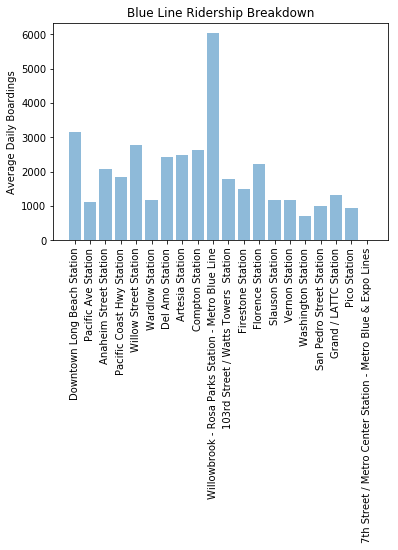

In [0]:
y_pos = np.arange(len(blue_ridership_df[0:20][["Station"]]))
stations = np.array(blue_ridership_df[0:20][["Station"]]).flatten()
boardings = np.array(blue_ridership_df[0:20][["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Blue Line Ridership Breakdown")


Collecting the dataframes from different lines and storing them into one list

In [0]:
line_ridership_df_list_17 = [blue_ridership_df, red_ridership_df, expo_ridership_df,
                      green_ridership_df, gold_ridership_df, purple_ridership_df]

line_ridership_list_aggregated = []

for line_df in line_ridership_df_list_17:
  line_ridership_aggregated = {}
  invalid_row_indicies = []
  for i in range(len(line_df.index)):
    daily_boardings = line_df.loc[i]['Average_Daily_Boardings']
    daytype = line_df.loc[i]['Daytype']
    
    if type(line_df.loc[i]['Station']) is not str:
      invalid_row_indicies.append(i)
      
    elif daily_boardings == 0 or isnan(daily_boardings):
      invalid_row_indicies.append(i)
      
    elif daytype != "Weekday":
      invalid_row_indicies.append(i)
      
    else:
      station = line_df.loc[i]['Station']
      lat = line_df.loc[i]['Latitude']
      lon = line_df.loc[i]['Longitude']
      
      if station in line_ridership_aggregated:
        line_ridership_aggregated[station]['daily_boardings'] += daily_boardings
      
      else:
        value = {'daily_boardings': daily_boardings, 'lat': lat, 'lon': lon}
        line_ridership_aggregated[station] = value
         
  line_df.drop(invalid_row_indicies, inplace=True)
  line_ridership_list_aggregated.append(line_ridership_aggregated)
  print(line_ridership_aggregated)

{'Downtown Long Beach Station': {'daily_boardings': 3165.275984433229, 'lat': 33.768071, 'lon': -118.192921}, 'Pacific Ave Station': {'daily_boardings': 1123.8540494658018, 'lat': 33.772258, 'lon': -118.1937}, 'Anaheim Street Station': {'daily_boardings': 2508.8023222847514, 'lat': 33.78183, 'lon': -118.189384}, 'Pacific Coast Hwy Station': {'daily_boardings': 2493.337958156897, 'lat': 33.78909, 'lon': -118.189382}, 'Willow Street Station': {'daily_boardings': 3887.0798860619743, 'lat': 33.807079, 'lon': -118.189834}, 'Wardlow Station': {'daily_boardings': 1562.9475960265388, 'lat': 33.819865, 'lon': -118.19609}, 'Del Amo Station': {'daily_boardings': 3116.437970001799, 'lat': 33.848222, 'lon': -118.211017}, 'Artesia Station': {'daily_boardings': 3342.715522376607, 'lat': 33.876082, 'lon': -118.222503}, 'Compton Station': {'daily_boardings': 3740.821724419464, 'lat': 33.89749, 'lon': -118.224249}, 'Willowbrook - Rosa Parks Station - Metro Blue Line': {'daily_boardings': 10197.994696967

Visualizing ridership breakdown for each row!

Text(0.5, 1.0, 'Red Line Ridership Breakdown')

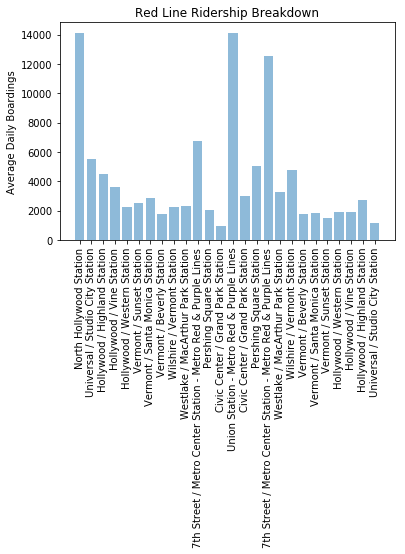

In [0]:
y_pos = np.arange(len(red_ridership_df[["Station"]]))
stations = np.array(red_ridership_df[["Station"]]).flatten()
boardings = np.array(red_ridership_df[["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Red Line Ridership Breakdown")

Text(0.5, 1.0, 'Expo Line Ridership Breakdown')

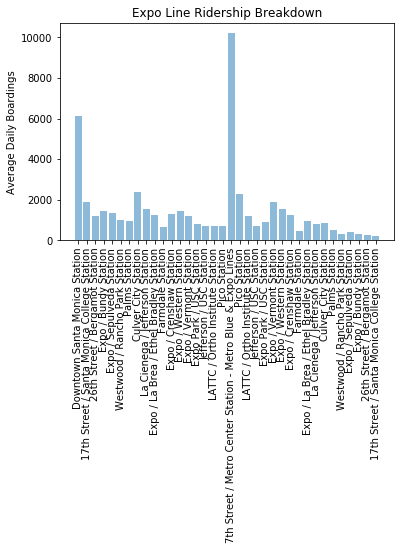

In [0]:
y_pos = np.arange(len(expo_ridership_df[["Station"]]))
stations = np.array(expo_ridership_df[["Station"]]).flatten()
boardings = np.array(expo_ridership_df[["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Expo Line Ridership Breakdown")

Aggregating ridership values for both *directions*

In [0]:
# y_pos = np.arange(len(line_ridership_dict))
# stations = []
# boardings = []
# for station, value in line_ridership_dict.items():
#   stations.append(station)
#   boardings.append(value['daily_boardings'])

# plt.bar(y_pos, boardings, align='center', alpha=0.5)
# plt.xticks(y_pos, stations)
# plt.xticks(rotation='vertical')
# plt.ylabel("Average Daily Boardings")
# plt.title("Blue Line Ridership Breakdown")

Visualizing ridership breakdown for each row!

In [0]:
# y_pos = np.arange(len(red_ridership_df[["Station"]]))
# stations = np.array(red_ridership_df[["Station"]]).flatten()
# boardings = np.array(red_ridership_df[["Average_Daily_Boardings"]].values).flatten()

# plt.bar(y_pos, boardings, align='center', alpha=0.5)
# plt.xticks(y_pos, stations)
# plt.xticks(rotation='vertical')
# plt.ylabel("Average Daily Boardings")
# plt.title("Red Line Ridership Breakdown")

By looking at the data, we can observe that some rows have empty values for stations and zero/NaN values for daily boardings. To clean up our data, we want to remove these rows from our dataframes. Here is a function that helps us with the removal.

In [0]:
def invalid_rows_to_remove(df):
  invalid_row_indicies = []
  for i in range(len(df.index)):
    station = df.loc[i]['Station']
    daily_boardings = df.loc[i]['Daily Boardings']
    if type(station) is not str:
      invalid_row_indicies.append(i)
  
    elif daily_boardings == 0 or isnan(daily_boardings):
      invalid_row_indicies.append(i)
  
  return invalid_row_indicies

##Retrieving Metro Data for All Lines

We will redefine the create_aggregated_ridership function by adding a second parameter which contains a dataframe with the latitude and longitude coordinates for each station. We will pass in a dataframe that is derived from the 2017 Metro Ridership database (which has columns for latitude and longitude).

In [0]:
# def create_aggregated_ridership_with_geocoordinates(df, geo_df):
#   line_ridership_aggregated = {}
#   empty_stations = 0
#   for i in range(len(df.index)):
#     station = df.loc[i]['Station']
#     daily_boardings = df.loc[i]['Average_Daily_Boardings']
#     if type(station) is not str:
#       if empty_stations == 2:
#         break
        
#       else:
#         empty_stations += 1
  
#     elif daily_boardings == 0 or isnan(daily_boardings):
#       continue
      
#     else:
#       if station in line_ridership_aggregated:
#         line_ridership_aggregated[station]['daily_boardings'] += daily_boardings
#       else:
#         lat = geo_df.loc[i]['Latitude']
#         lon = geo_df.loc[i]['Longitude']
#         value = {'daily_boardings': daily_boardings, 'lat': lat, 'lon': lon}
#         line_ridership_aggregated[station] = value
        
#   return line_ridership_aggregated

# Shapefile and Census data mapped across tracts

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os
os.listdir("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/")

['tl_2018_06_tract.shx',
 'tl_2018_06_tract.prj',
 'tl_2018_06_tract.shp.iso.xml',
 'tl_2018_06_tract.cpg',
 'tl_2018_06_tract.dbf',
 'tl_2018_06_tract.shp.ea.iso.xml',
 'tl_2018_06_tract.shp']

Looking at the properties of census tracts we are interested in

In [0]:
                                                                                                                                                                          
# open shapefile with fiona                                                                                                                                                                                 
with fiona.open("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/tl_2018_06_tract.shp", "r") as f:                                                                                                                                         
      # get first item in shape iterator                                                                                                                                                                    
      it = iter(f)                                                                                                                                                                                          
      example_data = next(it)                                                                                                                                                                               
      print("fiona parsed us an object of type:", type(example_data))                                                                                                                                       
                                                                                                                                                                                                            
print("Keys specifying shape info", example_data.keys())                                                                                                                                                    
                                                                                                                                                                                                            
print("keys:", example_data["geometry"].keys())                                                                                                                                                             
print("coordinates:", example_data["geometry"]["coordinates"])                                                                                                                                              
max_coord = max(example_data["geometry"]["coordinates"])                                                                                                                                                    
min_coord = min(example_data["geometry"]["coordinates"])                                                                                                                                                    
                                                                                                                                                                                                            
print("type:", example_data["geometry"]["type"])                                                                                                                                                            
                                                                                                                                                                                                            
print("keys:", example_data["properties"].keys())                                                                                                                                                           
for k in example_data["properties"].keys():                                                                                                                                                                 
      print(example_data["properties"][k])                                                                                                                                                                  
                                                                                                                                                                                                            
print("geoid:", example_data["properties"]["GEOID"])                                                                                                                                                        


fiona parsed us an object of type: <class 'dict'>
Keys specifying shape info dict_keys(['type', 'id', 'properties', 'geometry'])
keys: dict_keys(['type', 'coordinates'])
coordinates: [[(-118.581186, 34.143176), (-118.580994, 34.143341), (-118.580899, 34.143571), (-118.580927, 34.143786), (-118.580891, 34.144047), (-118.58094, 34.14423), (-118.580847, 34.14443), (-118.580915, 34.144628), (-118.580912, 34.144997), (-118.580214, 34.145547), (-118.580124, 34.145652999999996), (-118.580072, 34.145738), (-118.580036, 34.145829), (-118.580018, 34.145922999999996), (-118.580013, 34.146277999999995), (-118.579994, 34.147815), (-118.579988, 34.148282), (-118.57996800000001, 34.149885999999995), (-118.579955, 34.150079999999996), (-118.57983300000001, 34.151289), (-118.579702, 34.152585), (-118.579639, 34.153175), (-118.579521, 34.154343), (-118.579411, 34.155438), (-118.579311, 34.156435), (-118.579205, 34.157481), (-118.577684, 34.157498), (-118.577584, 34.157508), (-118.577427, 34.157536), (-1

Since we're interested only in census tracts in LA county, we will check each census tract shape item within the dataset and append it to our own data if it's in LA county, which means STATEFP is 6 (which is California) and COUNTYFP is 37 (which is Los Angeles County).

In [0]:
la_shapes = list()                                                                                                                                                                                          
with fiona.open("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/tl_2018_06_tract.shp", "r") as f:                                                                                                                                         
     # print("orig len", len(f))                                                                                                                                                                             
      for shape in f:                                                                                                                                                                                       
            if shape["properties"]["STATEFP"]=='06' and shape["properties"]["COUNTYFP"]=='037':                                                                                                             
                  la_shapes.append(shape)      


Now that we have the shape files for each census tract in LA county, we want to map census tract data to the geographical shape file that we extracted above.

In [0]:
census_tract_data = {}                                                                                                                                                                                      
# open the census data for reading                                                                                                                                                                          
with open("/gdrive/Team Drives/CSCI499 Final Proj /ACS_2017_5yr.csv", "r") as f: # awful filename                                                                                                                                                
  # parse out header                                                                                                                                                                                    
  p = f.readline().replace(","," ").split()                                                                                                                                                             
  print('p1', p)                                                                                                                                                                                        
                                                                                                               
  header = p                                                                                                                                                                                            
  f.readline()                                                                                                                                                                                          
# iterate over remaining lines                                                                                                                                                                        
  for line in f:                                                                                                                                                                                                                                                                                                                                            

      compos = [-1] # compos stores the positions of the relevant commas in the argument string                                                                                                       
      compos.extend(t[2][1] for t in generate_tokens(StringIO(line).readline) if t[1] == ',')                                                                                                         
      compos.append(len(line))                                                                                                                                                                        
      parts = [ line[compos[i]+1:compos[i+1]] for i in xrange(len(compos)-1)]                                                                                                                         
                                                                                                                                                             
      assert len(header) == len(parts)                                                                                                                                                                
      # create dictionary tracking data                                                                                                                                                               
      line = dict(zip(header, parts))                                                                                                                                                                 
      #print(line)                                                                                                                                                                                     
      # add to file using FIPS name                                                                                                                                                                                                                                                                                                                                          
      census_tract_data[line['Geo_TRACT']] = line                                                                                                                                                     


print(header)                                                                                                                                                                                               

la_shapes_ids = map(lambda x:x[0], la_shapes)  

p1 ['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB', 'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATECE', 'Geo_STATE', 'Geo_COUNTY', 'Geo_COUSUB', 'Geo_PLACE', 'Geo_PLACESE', 'Geo_TRACT', 'Geo_BLKGRP', 'Geo_CONCIT', 'Geo_AIANHH', 'Geo_AIANHHFP', 'Geo_AIHHTLI', 'Geo_AITSCE', 'Geo_AITS', 'Geo_ANRC', 'Geo_CBSA', 'Geo_CSA', 'Geo_METDIV', 'Geo_MACC', 'Geo_MEMI', 'Geo_NECTA', 'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA', 'Geo_UACP', 'Geo_CDCURR', 'Geo_SLDU', 'Geo_SLDL', 'Geo_VTD', 'Geo_ZCTA3', 'Geo_ZCTA5', 'Geo_SUBMCD', 'Geo_SDELM', 'Geo_SDSEC', 'Geo_SDUNI', 'Geo_UR', 'Geo_PCI', 'Geo_TAZ', 'Geo_UGA', 'Geo_BTTR', 'Geo_BTBG', 'Geo_PUMA5', 'Geo_PUMA1', 'SE_A00001_001', 'SE_A00002_001', 'SE_A00002_002', 'SE_A00002_003', 'SE_A00003_001', 'SE_A00003_002', 'SE_A00003_003', 'SE_A02001_001', 'SE_A02001_002', 'SE_A02001_003', 'SE_A01001_001', 'SE_A01001_002', 'SE_A01001_003', 'SE_A01001_004', 'SE_A01001_005', 'SE_A01001_006', 'SE_A0

Here we're defining the radius we're using to determine the census tract information we're using based on whether or not a census tract falls within a metro station's defined radius. You can change this radius value to see different prediction values.

In [0]:
FACTOR = 68.75                                                                                                                                                                                        
TRACT_RADIUS = 3
TRAFFIC_RADIUS = 1.5


Here we define the function that returns all the traffic counts based on a given latitude and longitude (a location point).

In [0]:
all_intersections = list()
def getNearbyTrafficIntersections(lat, lon):
  lat = lat*FACTOR                                                                                                                                                                                      
  lon = lon*FACTOR                                                                                                                                                                                      
  
  nearbyIntersections = list()
  
  traffic_df = pd.read_csv("/gdrive/Team Drives/CSCI499 Final Proj /LADOT_Traffic_Counts_Summary_w_latLong.csv")
  #print(traffic_df.head())
  
  for index, row in traffic_df.iterrows():
    curr_lat = float(row["LAT"])*FACTOR
    curr_lon = float(row["LONG"])*FACTOR
    all_intersections.append(float(row["Total"]))
    if sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)<=TRAFFIC_RADIUS:
      nearbyIntersections.append(row["Total"])
#       print(row["Total"])
      
  
  return nearbyIntersections

# Function that takes lat, long and returns list of census 
# tracts near station
def getNearbyCensusTracts(lat, lon):                                                                                                                                                                        
                                                                                                                                                                                                
      lat = lat*FACTOR                                                                                                                                                                                      
      lon = lon*FACTOR                                                                                                                                                                                      
                                                                                                                                                                                                            
      nearby_shapes = list()                                                                                                                                                                                
                                                                                                                                                                                                            
      for s in la_shapes: 
            curr_lat = float(s["properties"]["INTPTLAT"])*FACTOR                                                                                                                                            
            curr_lon = float(s["properties"]["INTPTLON"])*FACTOR                                                                                                                                            
            if sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)<=TRACT_RADIUS:
            #if abs(lat-curr_lat)<=RADIUS and abs(lon-curr_lon)<=RADIUS:                                                                                                                                     
#                  print("lat diff: ", abs(lat-curr_lat), " and long diff: ", abs(lon-curr_lon))                                                                                                            
 #                 print("lat:", curr_lat,  "long:", curr_lon)                                                                                                                                              
                  nearby_shapes.append(s)                  
      
      return nearby_shapes
    




# Feature Exploration

To see if our features correlate with a metro station's ridership value, we want to visualize the relationship between each feature and the ridership value. 

Function to return r^2 value for line of best fit of feature and ridership correlation.

In [0]:
def get_rsquared_val(x,y):
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
  print('r^2: ', r_value**2)

## Average Household Income

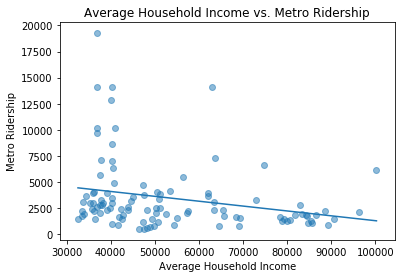

r^2:  0.06460183078114846


In [0]:
#blue_line_dict = line_ridership_list_aggregated[0]
stations = []
stations_avg_household_income = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
  #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    household_income_sum = 0
    nearby_tracts = getNearbyCensusTracts(lat,long)

    avg_household_incomes = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))

        income = (census_tract_data[tract_num_key]['SE_A14006_001']).strip()
        if income:
          avg_household_incomes.append(float(income))  
  #       print("IN:",income)

    new_avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)

    stations.append(station)
    stations_avg_household_income.append(new_avg_household_income)
    stations_ridership.append(value['daily_boardings'])
  

# Visualizing the relationship between average household income with ridership
x = stations_avg_household_income
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_avg_household_income, stations_ridership, alpha=0.5)
plt.title('Average Household Income vs. Metro Ridership')
plt.xlabel('Average Household Income')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

## Traffic Count

[38038.0, 38038.0, 38038.0, 38038.0, 0, 0, 0, 0, 5810.0, 1009579.0, 1421172.0, 1046845.0, 525666.0, 546541.0, 1068126.0, 1555176.0, 3074467.0, 3531436.0, 4537584.0, 6311687.0, 38038.0, 38038.0, 1470495.0, 853531.0, 2061113.0, 2907014.0, 2073335.0, 2449372.0, 2580788.0, 2543575.0, 3186073.0, 3705759.0, 6343273.0, 5466036.0, 4784981.0, 4326567.0, 39424.0, 55038.0, 260337.0, 709660.0, 1452156.0, 1719840.0, 947622.0, 974111.0, 1150543.0, 1450211.0, 1306012.0, 1344823.0, 2810856.0, 3506406.0, 3631533.0, 3812710.0, 3779890.0, 4537584.0, 6311687.0, 0, 15105.0, 51167.0, 58383.0, 134855.0, 0, 5327.0, 1068291.0, 1246575.0, 1515335.0, 1009579.0, 20560.0, 0, 27064.0, 50756.0, 50756.0, 76232.0, 706273.0, 1948415.0, 2427334.0, 3569891.0, 4884428.0, 4326433.0, 4015883.0, 1484846.0, 1212211.0, 1167541.0, 1591381.0, 31645.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3112961.0, 3274024.0, 3186073.0, 3705759.0, 6343273.0, 5466036.0, 4784981.0, 4326567.0]


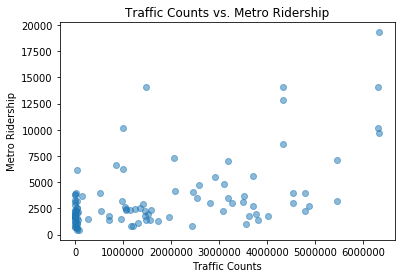

r^2:  0.3007703602185872


In [0]:
stations = []
stations_traffic_count = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
    (lat, long) = (value["lat"], value["lon"])

    nearby_intersections = getNearbyTrafficIntersections(lat,long)

    traffic_counts = 0

    for intersection in nearby_intersections:
        if not math.isnan(intersection):
          traffic_counts += (intersection)
        #  print("cnt:",traffic_counts)

    stations.append(station)   
    stations_traffic_count.append(traffic_counts)
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership
x = stations_traffic_count
y = stations_ridership
print(x)
plt.scatter(stations_traffic_count, stations_ridership, alpha=0.5)
plt.title('Traffic Counts vs. Metro Ridership')
plt.xlabel('Traffic Counts')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)  



## Population Density

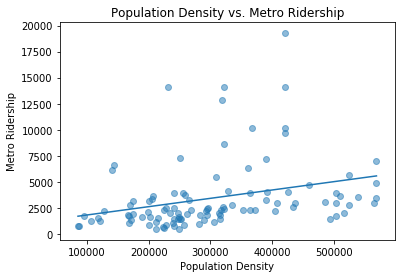

r^2:  0.08724482392461368


In [0]:
#blue_line_dict = line_ridership_list_aggregated[0]
stations = []
stations_total_pop_densities = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
  #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    pop_densities = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))

        pop_density = float(census_tract_data[tract_num_key]['SE_A00002_001'])
        pop_densities.append(pop_density)

    total_pop_densities = sum(pop_densities)
  #   print(station)
  #   print(total_pop_densities)

    stations.append(station)
    stations_total_pop_densities.append(total_pop_densities)
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership
x = stations_total_pop_densities
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_total_pop_densities, stations_ridership, alpha=0.5)
plt.title('Population Density vs. Metro Ridership')
plt.xlabel('Population Density')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

## Unemployed Over 16

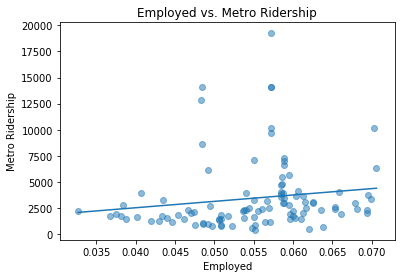

r^2:  0.023425359327033508


In [0]:
#blue_line_dict = line_ridership_list_aggregated[0]
stations = []
stations_total_pop_densities = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
  #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    employed_arr = []
    over_16_arr = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
        employed = float(census_tract_data[tract_num_key]['SE_A17002_006'])
        over_16 = float(census_tract_data[tract_num_key]['SE_A17002_001'])
        employed_arr.append(employed)
        over_16_arr.append(over_16)

    total_employed = sum(employed_arr)
    total_working_age = sum(over_16_arr)

    employed_frac = float(total_employed/total_working_age)
  #   print(station)
  #   print(total_pop_densities)

    stations.append(station)
    stations_total_pop_densities.append(employed_frac)
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership

x = stations_total_pop_densities
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_total_pop_densities, stations_ridership, alpha=0.5)
plt.title('Employed vs. Metro Ridership')
plt.xlabel('Employed')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

## Percent Population in Age Range 15-54

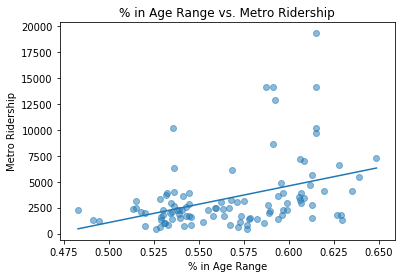

r^2:  0.15544678793161132


In [0]:
stations = []
stations_total_wanted_ages = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
    #if value['daily_boardings'] > 500:
    #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    total_pop = []
    range_pop = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
        overall = float(census_tract_data[tract_num_key]['SE_A01001_001'])
        want = 0
        for i in range(6,10):
          if i < 10:
            want += float(census_tract_data[tract_num_key]['SE_A01001_00'+str(i)])
          else:
            want += float(census_tract_data[tract_num_key]['SE_A01001_0'+str(i)])
        total_pop.append(overall)
        range_pop.append(want)

    overall = sum(total_pop)
    want = sum(range_pop)

    want_frac = float(want/overall)
  #   print(station)
  #   print(total_pop_densities)

    stations.append(station)
    stations_total_wanted_ages.append(want_frac)
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership

x = stations_total_wanted_ages
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_total_wanted_ages, stations_ridership, alpha=0.5)
plt.title('% in Age Range vs. Metro Ridership')
plt.xlabel('% in Age Range')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

##Number of Population Relying on Public Transportation to Get to Work

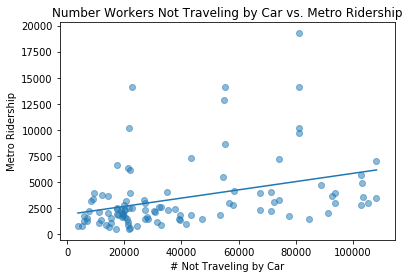

r^2:  0.12820286968915076


In [0]:
stations = []
stations_total_public_transportation = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
    #if value['daily_boardings'] > 500:
    #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    total_pop = []
    car_transport_pop = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
        working_pop = float(census_tract_data[tract_num_key]['SE_A09005_001'])
        car_pop = float(census_tract_data[tract_num_key]['SE_A09005_002'])
        total_pop.append(working_pop)
        car_transport_pop.append(car_pop)

    workers = sum(total_pop)
    car_workers = sum(car_transport_pop)
    want_frac = float(car_workers/workers)

#     print(station)
#     print(want_frac)

    stations.append(station)
    stations_total_public_transportation.append(float(workers-car_workers))
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership

x = stations_total_public_transportation
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_total_public_transportation, stations_ridership, alpha=0.5)
plt.title('Number Workers Not Traveling by Car vs. Metro Ridership')
plt.xlabel('# Not Traveling by Car')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

## Race

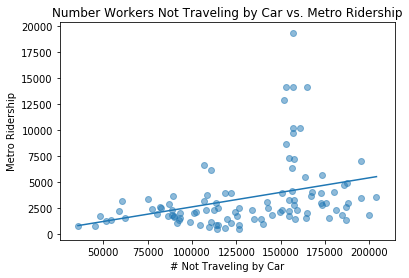

r^2:  0.11384821172849104


In [0]:
stations = []
stations_race_frac = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
    #if value['daily_boardings'] > 500:
    #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    total_pops = []
    race_pops = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
        total_pop = float(census_tract_data[tract_num_key]['SE_A03001_001'])
        #white
        race_pop = float(census_tract_data[tract_num_key]['SE_A03001_002']) 
        total_pops.append(total_pop)
        race_pops.append(race_pop)

    tot = sum(total_pops)
    want = sum(race_pops)
    want_frac = float(want/tot)

#     print(station)
#     print(want_frac)

    stations.append(station)
    stations_race_frac.append(want)
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership

x = stations_race_frac
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_race_frac, stations_ridership, alpha=0.5)
plt.title('Number Workers Not Traveling by Car vs. Metro Ridership')
plt.xlabel('# Not Traveling by Car')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

##Households without Retirement Income

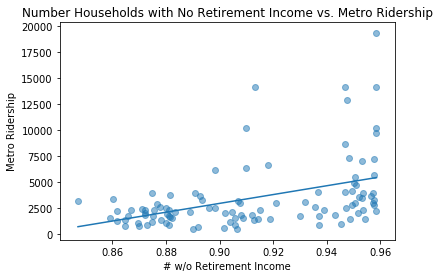

r^2:  0.18593180739902898


In [0]:
stations = []
stations_no_retirement = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
    #if value['daily_boardings'] > 500:
    #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    total_households = []
    pub_assistance = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
        total = float(census_tract_data[tract_num_key]['SE_A10015_001'])
        #white
        pub = float(census_tract_data[tract_num_key]['SE_A10015_003']) 
        total_households.append(total)
        pub_assistance.append(pub)

    total = sum(total_households)
    pub = sum(pub_assistance)
    want_frac = float(pub/total)    # fraction people without retirement income

#     print(station)
#     print(want_frac)

    stations.append(station)
    stations_no_retirement.append(want_frac)
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership

x = stations_no_retirement
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_no_retirement, stations_ridership, alpha=0.5)
plt.title('Number Households with No Retirement Income vs. Metro Ridership')
plt.xlabel('# w/o Retirement Income')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

##Number of Housing Units

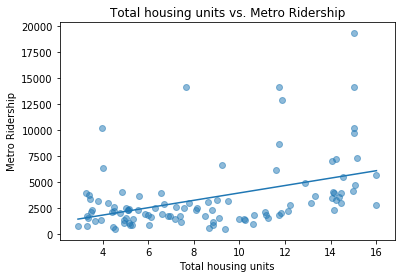

r^2:  0.18203303269331123


In [0]:
stations = []
stations_total_housing_units = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
  #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    no_vehicles = []
    occupied_housing = []
    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
        occupied = float(census_tract_data[tract_num_key]['SE_A10030_001'])
        occupied_housing.append(occupied)
        no_vehicle = float(census_tract_data[tract_num_key]['SE_A10030_006']) + float(census_tract_data[tract_num_key]['SE_A10030_007']) + float(census_tract_data[tract_num_key]['SE_A10030_005'])
        no_vehicles.append(no_vehicle)

    no_vehicle = sum(no_vehicles)
    occupied = sum(occupied_housing)
    no_vehicle_frac = float(no_vehicle/occupied)
  #   print(station)
  #   print(total_pop_densities)

    stations.append(station)
    stations_total_housing_units.append(float(1.0/no_vehicle_frac))
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership
x = stations_total_housing_units
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_total_housing_units, stations_ridership, alpha=0.5)
plt.title('Total housing units vs. Metro Ridership')
plt.xlabel('Total housing units')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

## Uber Data



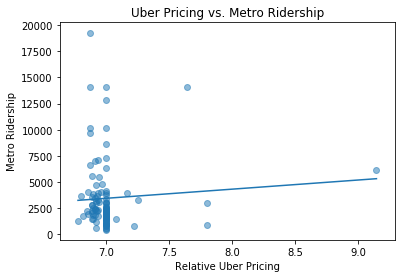

r^2:  0.0046836018394586275


In [0]:

import json
with open("/gdrive/Team Drives/CSCI499 Final Proj /tract_to_uber_data.json") as f:
  tract_to_uber_data = json.load(f)
f.close()

def getNearestCensusTract(lat, lon):                                                                                                                                                                        

  closest_tract = la_shapes[0]
  curr_lat = float(closest_tract["properties"]["INTPTLAT"])
  curr_lon = float(closest_tract["properties"]["INTPTLON"])
  closest_distance = sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)

  for s in la_shapes: 
    curr_lat = float(s["properties"]["INTPTLAT"])                                                                                                                                            
    curr_lon = float(s["properties"]["INTPTLON"])
    if sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2) < closest_distance:
      closest_tract = s
      closest_distance = sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)
  return closest_tract

stations = []
stations_uber_data = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
    (lat, long) = (value["lat"], value["lon"])

    nearest_tract = getNearestCensusTract(lat,long)

    stations.append(station)
    average_distance = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_distance'])

    combined_speed = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['combined_speed'])
    average_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_high_price'])/average_distance
    average_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_low_price'])/average_distance
    max_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['max_high_price'])/average_distance
    min_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['min_high_price'])/average_distance
    max_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['max_low_price'])/average_distance
    min_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['min_low_price'])/average_distance

    value_to_plot = average_distance*average_high_price # You can put different features created above to plot different ones

    stations_uber_data.append(value_to_plot)
    stations_ridership.append(value['daily_boardings'])

# Visualizing the relationship between average household income with ridership

x = stations_uber_data
y = stations_ridership
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.scatter(stations_uber_data, stations_ridership, alpha=0.5)
plt.title('Uber Pricing vs. Metro Ridership')
plt.xlabel('Relative Uber Pricing')
plt.ylabel('Metro Ridership')
plt.show()
get_rsquared_val(x,y)

# Creating Training Dataset

For each metro station, we draw a 2 mile radius: within that radius, we find which census tract belongs to that station and average the household income data and population density data, and also the number of traffic counts that's inside the tract. 

In [0]:
x = list()
y = list()
x_stations = []
for line_dict in line_ridership_list_aggregated:
  print("--------------------------------------LINE-------------------------")
  for station, value in line_dict.items():
    print(station)
    num_census_tracts = 0
    household_income_sum = 0
    population_density_sum = 0
    traffic_sum = 0
    (lat, long) = (value["lat"], value["lon"])
    print(lat, long)
    x_stations.append(station)

    nearby_tracts = getNearbyCensusTracts(lat,long)

    pop_densities = list()
    pop_totals = list()
    avg_household_incomes = list()
    total_pop = list()
    range_pop = list()
    want_frac = 0.0
    no_car = 0
    total_pop = list()
    car_transport_pop = list()
    total_households = list()
    pub_assistance = list()
    employed_arr = list()
    over_16_arr = list()
    total_pops = list()
    race_pops = list()

    for tract in nearby_tracts:
      tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
      #print("NUM: ", tract_num_key)
      pop_total = float(census_tract_data[tract_num_key]['SE_A00002_001'])
      pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
      pop_densities.append(pop_density)
      pop_totals.append(pop_total)
      #print("PD:",pop_density)

      income = (census_tract_data[tract_num_key]['SE_A14006_001']).strip()
      if income:
        avg_household_incomes.append(float(income))
      else:
        avg_household_incomes.append(float(69300))
      #print("IN:",income)

      overall = float(census_tract_data[tract_num_key]['SE_A01001_001'])
      want = 0
      for i in range(6,10):
        if i < 10:
          want += float(census_tract_data[tract_num_key]['SE_A01001_00'+str(i)])
        else:
          want += float(census_tract_data[tract_num_key]['SE_A01001_0'+str(i)])
      total_pop.append(overall)
      range_pop.append(want)

      working_pop = float(census_tract_data[tract_num_key]['SE_A09005_001'])
      car_pop = float(census_tract_data[tract_num_key]['SE_A09005_002'])
      total_pop.append(working_pop)
      car_transport_pop.append(car_pop)

      total = float(census_tract_data[tract_num_key]['SE_A10015_001'])
      pub = float(census_tract_data[tract_num_key]['SE_A10015_003']) 
      total_households.append(total)
      pub_assistance.append(pub)

      employed = float(census_tract_data[tract_num_key]['SE_A17002_006'])
      over_16 = float(census_tract_data[tract_num_key]['SE_A17002_001'])
      employed_arr.append(employed)
      over_16_arr.append(over_16)

      tot_pop = float(census_tract_data[tract_num_key]['SE_A03001_001'])
      #white
      race_pop = float(census_tract_data[tract_num_key]['SE_A03001_002']) 
      total_pops.append(tot_pop)
      race_pops.append(race_pop)



    nearby_intersections = getNearbyTrafficIntersections(lat,long)
    avg_traffic = np.nanmean(all_intersections)
    print("?",avg_traffic)
    print("!",len(nearby_intersections))
    traffic_counts = 0

    for intersection in nearby_intersections:
        if not math.isnan(intersection) and intersection != 0:
          traffic_counts += (intersection)
        else:
          traffic_counts += (avg_traffic)
        #  print("cnt:",traffic_counts)


    pop_density = sum(pop_densities)
    pop_total = sum(pop_totals)

    avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)

    overall = sum(total_pop)
    want = sum(range_pop)
    want_frac = float(want/overall)

    workers = sum(total_pop)
    car_workers = sum(car_transport_pop)
    no_car = float(workers-car_workers)

    total = sum(total_households)
    pub = sum(pub_assistance)
    no_retirement_frac = float(pub/total)

    total_employed = sum(employed_arr)
    total_working_age = sum(over_16_arr)
    employed_frac = float(total_employed/total_working_age)

    tot = sum(total_pops)
    want = sum(race_pops)
    race_frac = float(want/tot)


    # Uber data
    nearest_tract = getNearestCensusTract(lat,long)
    average_distance = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_distance'])

    ## Uber data features: combined_speed, average_high_price, average_low_price, max_high_price, min_high_price, max_low_price, min_low_price
    combined_speed = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['combined_speed'])
    average_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_high_price'])/average_distance
    average_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_low_price'])/average_distance
    max_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['max_high_price'])/average_distance
    min_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['min_high_price'])/average_distance
    max_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['max_low_price'])/average_distance
    min_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['min_low_price'])/average_distance


    # avg -> median, remove no_retirement_frac, want_frac, no_car
    #x.append([pop_density, pop_total, overall, want, want_frac, workers, car_workers, total, pub, no_retirement_frac, total_employed, total_working_age, tot, race_frac, traffic_counts, avg_household_income, employed_frac, no_car, combined_speed, average_high_price, average_low_price, max_high_price, max_low_price, min_high_price, min_low_price])
    x.append([traffic_counts, avg_household_income, employed_frac, race_frac, no_car, (combined_speed*average_distance)/average_high_price])#, (combined_speed*average_distance)/average_high_price])
    #x_train.append([want_frac])
    #print("avgPD:",avg_pop_density, " avgHI:",avg_household_income)

    daily_boarding = value['daily_boardings']
    y.append(daily_boarding)

x = np.array(x)
y = np.array(y)


  

--------------------------------------LINE-------------------------
Downtown Long Beach Station
33.768071 -118.192921
? 15254.55858638793
! 3
Pacific Ave Station
33.772258 -118.1937
? 15254.558639174371
! 3
Anaheim Street Station
33.78183 -118.189384
? 15254.558691889433
! 3
Pacific Coast Hwy Station
33.78909 -118.189382
? 15254.558744533264
! 3
Willow Street Station
33.807079 -118.189834
? 15254.558797106005
! 0
Wardlow Station
33.819865 -118.19609
? 15254.5588496078
! 0
Del Amo Station
33.848222 -118.211017
? 15254.558902038794
! 0
Artesia Station
33.876082 -118.222503
? 15254.55895439913
! 0
Compton Station
33.89749 -118.224249
? 15254.55900668895
! 1
Willowbrook - Rosa Parks Station - Metro Blue Line
33.928048 -118.237555
? 15254.559058908397
! 72
103rd Street / Watts Towers  Station
33.94222 -118.243159
? 15254.559111057612
! 103
Firestone Station
33.959611 -118.243205
? 15254.559163136737
! 79
Florence Station
33.97374 -118.243271
? 15254.559215145913
! 38
Slauson Station
33.9887

In [0]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot


x_test = []
y_test = []
x_train = []
y_train = []
x_test_stations = []

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print("RF r^2:",metrics.r2_score(test_labels, predictions))
    print("MSE r^2:",metrics.mean_squared_error(test_labels, predictions))
    
    return accuracy

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
# params={
#     'max_depth': [9], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
#     'subsample': [1.0], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#     'colsample_bytree': [0.8], #[0.5,0.6,0.7,0.8],
#     'n_estimators': [3000], #[1000,2000,3000]
#     'reg_alpha': [0.04] #[0.01, 0.02, 0.03, 0.04]
# }

xgbmodel = xgb.XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgbmodel, params, cv = 10, n_jobs = -1, verbose = 2)



## Testing Data: Cross Validation

TRAIN: [ 11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103] TEST: [ 0  1  2  3  4  5  6  7  8  9 10]
XGBoost r^2: 0.289295474231684
MSE r^2: 3684607.482175002


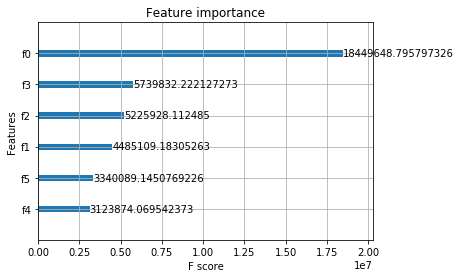

   feature  importance
0      f0         159
1      f2         100
3      f1          76
5      f4          59
4      f3          55
2      f5          39
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 2500 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   48.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.06396199331063057


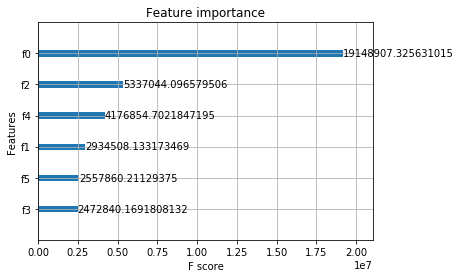

Model Performance
Average Error: 1367.2366 degrees.
Accuracy = 63.28%.
RF r^2: 0.3666938493798618
MSE r^2: 3283339.9767079963
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103] TEST: [11 12 13 14 15 16 17 18 19 20 21]
XGBoost r^2: 0.8236893838724736
MSE r^2: 2245196.46823981


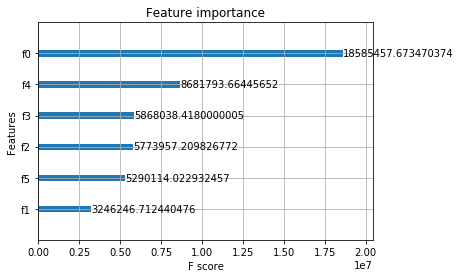

   feature  importance
1      f2         127
0      f0         106
3      f1          84
4      f3          79
2      f5          53
5      f4          46
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   48.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8952926890441665


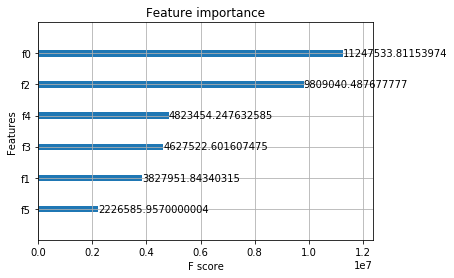

Model Performance
Average Error: 1225.4130 degrees.
Accuracy = 21.88%.
RF r^2: 0.7607336013928834
MSE r^2: 3046895.78495147
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103] TEST: [22 23 24 25 26 27 28 29 30 31 32]
XGBoost r^2: -0.2808675232572224
MSE r^2: 27731332.22032211


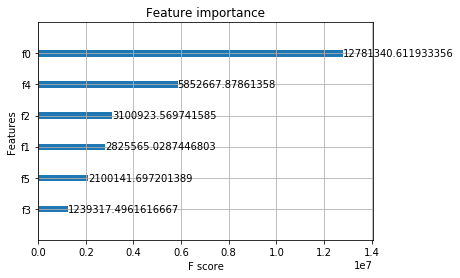

   feature  importance
0      f0         137
1      f2         101
4      f1          94
5      f4          81
3      f5          72
2      f3          30
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 3084 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   48.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-0.33561131808372324


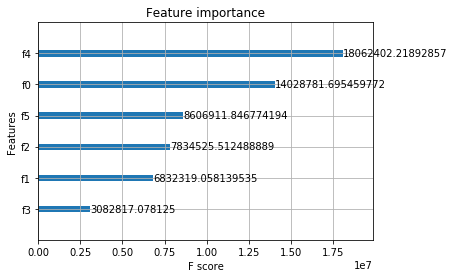

Model Performance
Average Error: 3942.5240 degrees.
Accuracy = 53.32%.
RF r^2: -0.2514755438121776
MSE r^2: 27094983.236681174
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103] TEST: [33 34 35 36 37 38 39 40 41 42 43]
XGBoost r^2: -0.2397655107026575
MSE r^2: 16977894.02952442


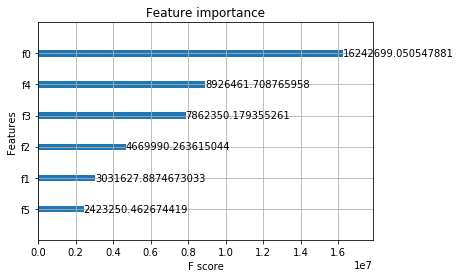

   feature  importance
0      f0         141
3      f2         113
4      f1          89
1      f3          76
2      f4          47
5      f5          43
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   49.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.44887173416188464


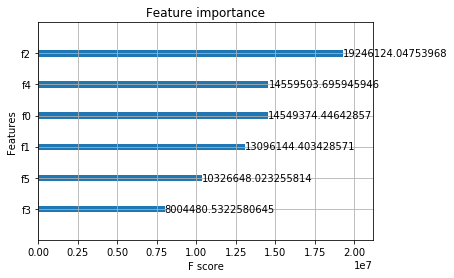

Model Performance
Average Error: 4671.3652 degrees.
Accuracy = -133.65%.
RF r^2: -1.032963268549735
MSE r^2: 27840292.895219196
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103] TEST: [44 45 46 47 48 49 50 51 52 53]
XGBoost r^2: -5.204807894578455
MSE r^2: 2548420.7963245194


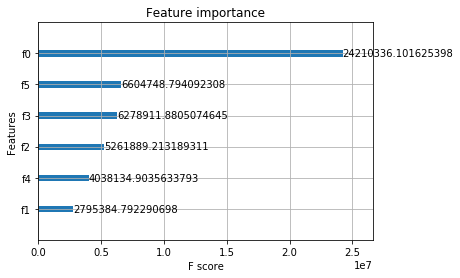

   feature  importance
1      f2         131
0      f0         113
2      f1          86
5      f4          71
4      f3          67
3      f5          39
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   48.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-6.968442699775583


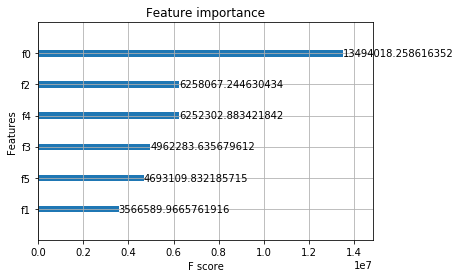

Model Performance
Average Error: 1366.7270 degrees.
Accuracy = 31.83%.
RF r^2: -5.477401640551072
MSE r^2: 2660379.7131818184
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103] TEST: [54 55 56 57 58 59 60 61 62 63]
XGBoost r^2: 0.6568165529526169
MSE r^2: 2369488.4223653553


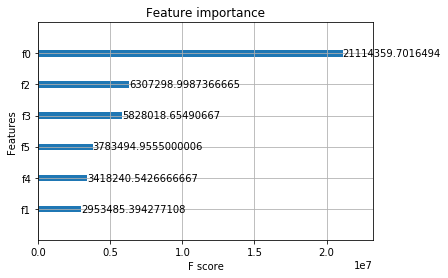

   feature  importance
1      f2         120
0      f0         117
5      f1          83
2      f4          75
3      f3          75
4      f5          44
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 3084 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   49.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7903943036983478


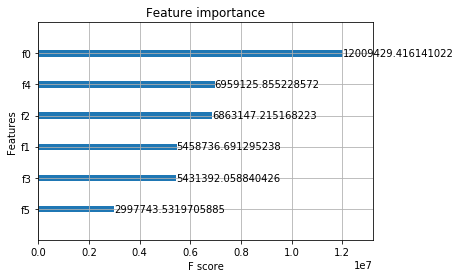

Model Performance
Average Error: 1066.0290 degrees.
Accuracy = 43.75%.
RF r^2: 0.7020899519526426
MSE r^2: 2056901.100061093
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103] TEST: [64 65 66 67 68 69 70 71 72 73]
XGBoost r^2: -1.2981730568135021
MSE r^2: 6004262.819847421


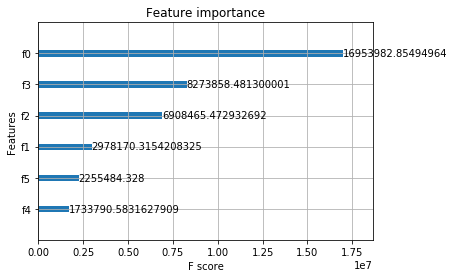

   feature  importance
0      f0         167
1      f2         104
3      f3          70
2      f5          52
4      f1          48
5      f4          43
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   49.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-2.2036104897796456


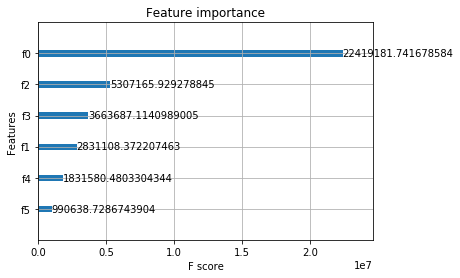

Model Performance
Average Error: 1396.8965 degrees.
Accuracy = -23.84%.
RF r^2: 0.03512939629253553
MSE r^2: 2520844.40491924
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103] TEST: [74 75 76 77 78 79 80 81 82 83]
XGBoost r^2: 0.5744642172649865
MSE r^2: 5111125.49522933


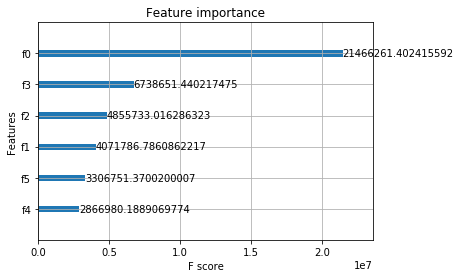

   feature  importance
4      f2         117
0      f0         109
3      f1          98
2      f3          87
5      f5          50
1      f4          43
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   49.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.28949724089252427


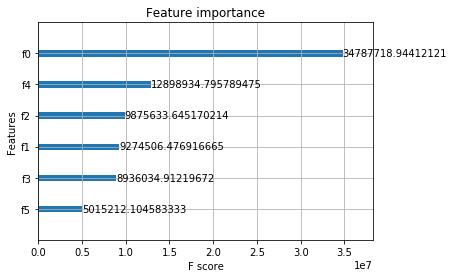

Model Performance
Average Error: 2487.3792 degrees.
Accuracy = -80.52%.
RF r^2: 0.2893016501667116
MSE r^2: 8536223.280457517
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  94  95  96  97  98  99
 100 101 102 103] TEST: [84 85 86 87 88 89 90 91 92 93]
XGBoost r^2: -0.12458012634529791
MSE r^2: 419508.10857065953


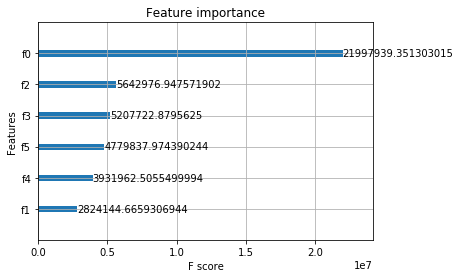

   feature  importance
1      f2         121
0      f0         116
2      f1         101
4      f3          96
5      f4          60
3      f5          41
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   50.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-0.3661093757004792


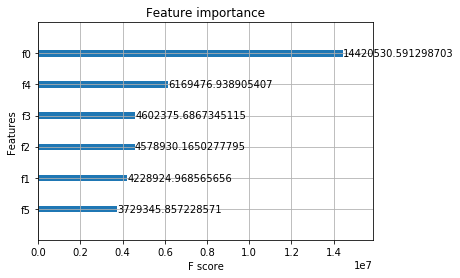

Model Performance
Average Error: 513.3855 degrees.
Accuracy = 57.25%.
RF r^2: 0.08145450158514611
MSE r^2: 342649.91497617203
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93] TEST: [ 94  95  96  97  98  99 100 101 102 103]
XGBoost r^2: -0.9318149397477686
MSE r^2: 13751813.584912926


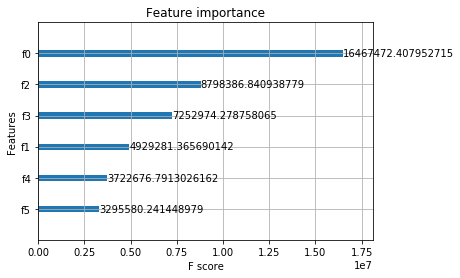

   feature  importance
0      f0         162
1      f2          98
3      f1          71
2      f4          65
5      f3          62
4      f5          49
Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:   49.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-0.30148023581134176


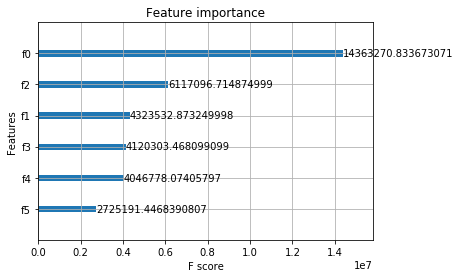

Model Performance
Average Error: 2195.5061 degrees.
Accuracy = 42.11%.
RF r^2: -0.24120762904680149
MSE r^2: 8835657.900570951


In [0]:






kf = KFold(n_splits=10)
kf.get_n_splits(x)
for train_index, test_index in kf.split(x):
  print("TRAIN:", train_index, "TEST:", test_index)
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


  xgb_model = xgb.XGBRegressor()
  
  xgb_model.fit(x_train, y_train)
  y_pred = xgb_model.predict(x_test)
  print("XGBoost r^2:", metrics.r2_score(y_test, y_pred))
  print("MSE r^2:",metrics.mean_squared_error(y_test, y_pred))
  
  plot_importance(xgb_model, importance_type='gain')
  pyplot.show()
  
  xgb_fea_imp=pd.DataFrame(list(xgb_model.get_booster().get_fscore().items()),
  columns=['feature','importance']).sort_values('importance', ascending=False)
  print('',xgb_fea_imp)
  xgb_fea_imp.to_csv('xgb_fea_imp.csv')
  
  grid.fit(x_train, y_train)
#   print(grid.cv_results_)
  predictions = grid.best_estimator_.predict(x_test)
  print(r2_score(y_test, predictions))
  
  plot_importance(grid.best_estimator_, importance_type='gain')
  pyplot.show()



  base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
  base_model.fit(x_train, y_train)
  base_accuracy = evaluate(base_model, x_test, y_test)



## Creating Machine Learning Model

Import Python packages for Linear Regression and XG Boost

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [0]:
np.set_printoptions(threshold=sys.maxsize)

print(x_train)
x_train.shape
#y_train.reshape(405,1)
#y_train.shape

[[3.80380000e+04 4.57647826e+04 5.66704523e-02 5.30456613e-01
  2.21798000e+05 1.87889470e+00]
 [3.80380000e+04 4.81502245e+04 5.64540444e-02 5.23570584e-01
  2.32718000e+05 1.87889470e+00]
 [3.80380000e+04 5.14235741e+04 5.43916026e-02 5.26493607e-01
  2.63140000e+05 1.74484585e+00]
 [3.80380000e+04 5.06572830e+04 5.69063048e-02 5.01972975e-01
  2.49611000e+05 2.35849278e+00]
 [0.00000000e+00 5.17674333e+04 5.84392070e-02 4.78036013e-01
  2.77006000e+05 3.97527839e+00]
 [0.00000000e+00 5.58463654e+04 6.02052563e-02 4.33099625e-01
  2.30049000e+05 3.35586266e+00]
 [0.00000000e+00 6.36740263e+04 6.25639505e-02 3.47838045e-01
  1.82963000e+05 6.00106230e+00]
 [0.00000000e+00 5.13423095e+04 6.99112383e-02 3.65457462e-01
  2.14324000e+05 8.28879812e+00]
 [5.81000000e+03 4.76042745e+04 6.95197347e-02 4.19540674e-01
  2.70980000e+05 3.40858549e+00]
 [1.00957900e+06 4.09212703e+04 7.02717990e-02 4.37227012e-01
  3.89286000e+05 3.57348800e+00]
 [1.42117200e+06 3.83562558e+04 6.78029025e-02 4.3

(94, 6)

fcn

In [0]:
def loo_score(model):
  loo = LeaveOneOut()
  ytests = []
  ypreds = []
  for train_idx, test_idx in loo.split(x):
      x_train, x_test = x[train_idx], x[test_idx] #requires arrays
      y_train, y_test = y[train_idx], y[test_idx]

      #model = LinearRegression()
      model.fit(x_train, y_train) 
      y_pred = model.predict(x)

      # there is only one y-test and y-pred per iteration over the loo.split, 
      # so to get a proper graph, we append them to respective lists.
      print(ytests)
      print(ypreds)
      ytests.append(list(y_test))
      ypreds.append(list(y_pred))

  rr = metrics.r2_score(ytests, ypreds)
  ms_error = metrics.mean_squared_error(ytests, ypreds)

  print("Leave One Out Cross Validation")
  print("R^2: {:.5f}%, MSE: {:.5f}".format(rr*100, ms_error))

Instantiating the model and training the model

[-8.86722980e-01 -1.17865152e+00 -8.67033764e+00 -2.36785455e-01
 -3.93499562e+00 -4.35440801e-01 -1.84341107e+00  3.62017916e-01
 -2.38730421e+02 -2.14977115e+00 -1.07075903e-01 -1.09915953e+02
 -9.15065778e-01 -1.75569312e+01 -7.08601817e-01 -5.37988431e-01
  3.60105981e-01 -1.73669970e+02 -1.31935133e+02  1.06049643e-01
 -3.00130412e+01 -2.53291497e-01 -1.04789225e+03 -4.06825780e+02
 -3.40089808e+01  9.46718963e-01 -4.87721160e+02  1.54306723e-01
 -4.94037801e+01 -1.28996222e+02  3.96039720e-03 -1.39977207e+02
 -1.54776348e+01 -6.00375506e+02 -3.76244258e+02 -4.12304405e+03
 -2.73230340e-01 -2.85713697e+02 -4.58970210e+04 -1.78019416e+01
 -5.01955534e+03 -2.60540442e+01 -1.09578531e+02 -8.49907720e+01
 -2.25166662e+04 -1.23251057e+02 -6.46589878e-01 -1.14457326e+01
 -1.77020494e-01 -3.98049764e-01]
Cross-Predicted Accuracy: 0.28451027840498455


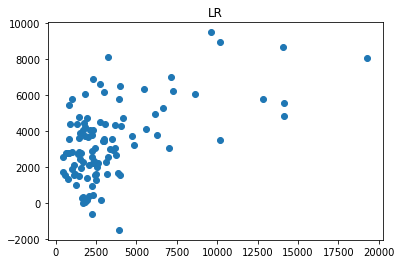

[-1.31508083e-02 -9.32060717e-02 -1.78097801e+01 -7.03278085e-01
 -7.95928190e-01 -7.82370960e-01 -6.93839900e-01 -1.24942021e+00
 -6.50342879e+02 -4.66236150e+00 -2.02153285e+01 -1.74982987e+03
 -9.09373721e+00 -2.11332744e+01 -2.65421922e+00 -1.29998881e+00
 -8.03075550e-01 -2.05891441e+01 -1.23241091e+01 -4.66655998e-05
 -3.74812450e+00 -5.64445330e-01 -4.62728426e+02 -2.84367783e+01
  3.55495849e-01 -1.53110505e-01 -2.90116962e+02 -1.53064832e-02
 -1.91333439e+00 -2.26208732e+00 -6.99449075e-01 -3.83555584e+00
 -4.64509009e-01 -4.51460273e+02 -5.12197404e+01 -5.01862666e+02
 -1.16628770e+00 -1.69943900e+01 -7.87764123e+03 -1.42500598e+00
 -1.08907248e+03 -2.70384978e-03 -2.76186765e+00 -9.12422680e+02
 -2.71231508e+04 -7.58373346e+01 -2.85424884e+00 -5.38711775e-01
 -9.33270461e-01 -4.34151684e-01]
Cross-Predicted Accuracy: 0.007269639133005379


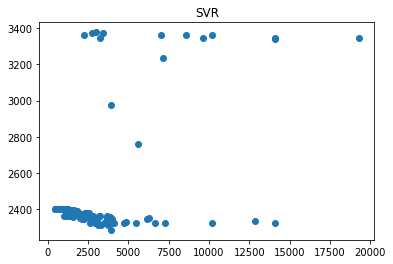

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Model Performance
Average Error: 1615.4502 degrees.
Accuracy = 42.71%.
RF r^2: -0.2290085962593722
MSE r^2: 4179536.173520735
Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.0min finished


Model Performance
Average Error: 1708.1843 degrees.
Accuracy = 37.05%.
RF r^2: -0.40205919428501113
MSE r^2: 4768035.90940453
grid acc:  37.04642480769025


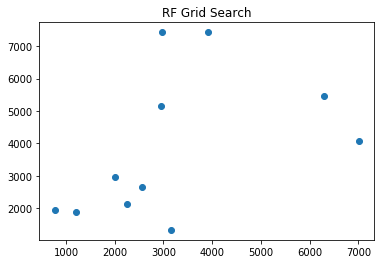

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   13.5s finished


-0.831848071721546
0.46520191815449197
{'colsample_bytree': 0.6, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6}


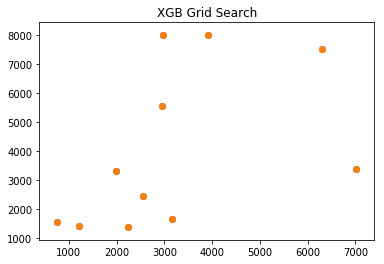

[-6.60530731e-01 -4.02329962e-01 -2.04653797e+01  4.09277490e-01
 -4.99148955e-01  3.55102387e-01 -3.50023256e+00  9.06974979e-01
 -3.22489694e+02 -2.09023321e+00 -8.22156327e+00 -5.74336781e+02
 -5.81248058e+00 -1.78231228e+01 -1.49933179e-01  4.39344082e-01
 -1.18451332e+00 -1.37963522e+01 -4.98374850e+01 -2.52081224e+00
 -6.57618373e+02 -3.76740164e+01 -1.55956695e+03 -6.64894773e+01
 -1.52100332e+01  7.41973682e-01 -2.16262970e+02  7.44628743e-01
 -2.47219126e+01 -2.50862842e+02  8.48525056e-01 -1.67423572e+02
 -2.35274182e+00 -2.09435329e+02 -1.30877824e+02 -2.62147125e+03
  4.21675108e-01 -5.34273275e+01 -1.11366846e+04 -1.06675568e+01
 -1.03614315e+03 -3.06887920e+00 -5.97874424e+00 -8.18882015e+01
 -1.46657794e+04 -8.99373189e+01 -7.51189658e-01 -4.55160626e+01
 -1.47204519e-01  2.17112467e-01]
Cross-Predicted grid2 Accuracy: 0.5275130549957733


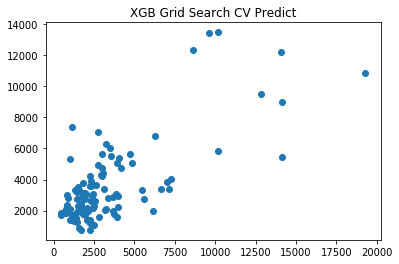

Fitting 5 folds for each of 8 candidates, totalling 40 fits
-0.024480399541697912
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
Lin Predicted Accuracy: 0.3621703506091065


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


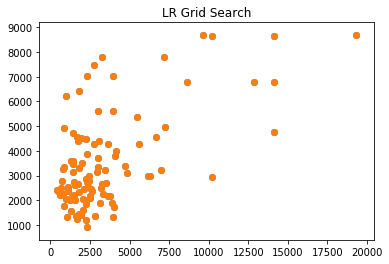

[-8.11712559e-01  1.00032877e-01 -9.35577781e+01  3.86853176e-01
 -1.80886120e+00 -5.50490730e-01 -3.75660684e-01  7.09294665e-01
 -1.77908462e+02 -3.08762197e+00 -8.46612047e+00 -1.05675548e+02
 -1.34498634e+00 -1.97212182e+01 -3.67550561e-01  3.63901033e-01
 -7.85377501e-01 -1.99782419e+01 -2.07427180e+01 -1.40793375e+00
 -8.40283700e+00 -4.55518711e+00 -9.61263048e+01 -8.88440468e+01
 -4.71820891e+00  6.18035600e-01 -4.64625404e+01  6.95570020e-01
 -8.11823277e+00 -7.81249232e+01 -1.54964753e-01 -1.66371673e+01
 -1.68781182e+00 -5.28907158e+02 -7.01187875e+01 -5.98540290e+02
  5.63313642e-01 -5.62922601e+00 -3.61802497e+03  3.31697981e-01
 -4.58977914e+02 -2.45445451e+00 -6.36991325e+00 -8.67135752e+01
 -8.22535985e+03 -5.04887787e+01 -1.14792309e+00 -5.53392440e+01
 -3.48641014e+00  1.74706207e-02]
Cross-Predicted Accuracy: 0.47262520206341707


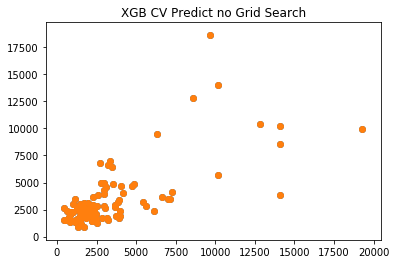

[-5.26482179e-01 -8.43267043e-02 -1.78071110e+01  2.74604634e-01
  1.81329769e-02 -1.86380907e+00 -9.10305071e-01  9.41095138e-01
 -2.21951870e+02 -2.29836058e+00 -4.12749458e+00 -5.65414725e+02
 -1.27467857e+01 -2.11797880e+01 -1.29160859e-01  5.14570784e-01
 -4.13908766e-01 -6.61852039e+01 -5.02460341e+01 -2.53251267e+00
 -3.01094621e+02 -1.83583777e+01 -2.70036680e+03 -1.44058134e+02
 -5.65869923e+00  7.07937001e-01 -8.12825594e+01  7.33057090e-01
 -1.72258366e+01 -3.30101202e+01  4.16818196e-01 -1.00973236e+02
 -1.95541814e+00 -3.65944097e+02 -5.81604616e+01 -3.32658568e+03
  4.88807090e-01 -5.72906499e+01 -6.40606418e+03 -5.45876494e+00
 -8.98148691e+02 -3.07113058e+00 -6.78716692e+00 -1.24708633e+01
 -1.31720181e+04 -1.10596219e+02 -7.00680564e-01 -3.78580213e+01
 -3.84107819e-01  1.50628805e-01]
Cross-Predicted Accuracy: 0.5449559432839031


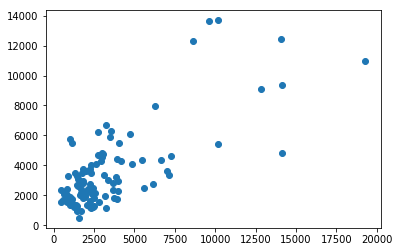

[-8.11712559e-01  1.00032877e-01 -9.35577781e+01  3.86853176e-01
 -1.80886120e+00 -5.50490730e-01 -3.75660684e-01  7.09294665e-01
 -1.77908462e+02 -3.08762197e+00 -8.46612047e+00 -1.05675548e+02
 -1.34498634e+00 -1.97212182e+01 -3.67550561e-01  3.63901033e-01
 -7.85377501e-01 -1.99782419e+01 -2.07427180e+01 -1.40793375e+00
 -8.40283700e+00 -4.55518711e+00 -9.61263048e+01 -8.88440468e+01
 -4.71820891e+00  6.18035600e-01 -4.64625404e+01  6.95570020e-01
 -8.11823277e+00 -7.81249232e+01 -1.54964753e-01 -1.66371673e+01
 -1.68781182e+00 -5.28907158e+02 -7.01187875e+01 -5.98540290e+02
  5.63313642e-01 -5.62922601e+00 -3.61802497e+03  3.31697981e-01
 -4.58977914e+02 -2.45445451e+00 -6.36991325e+00 -8.67135752e+01
 -8.22535985e+03 -5.04887787e+01 -1.14792309e+00 -5.53392440e+01
 -3.48641014e+00  1.74706207e-02]
Cross-Predicted Accuracy: 0.47262520206341707


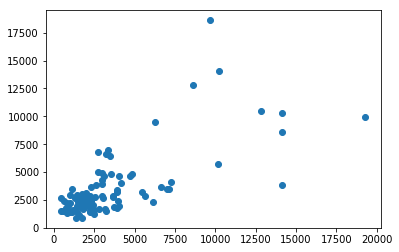

In [0]:

folds = 50

# Linear Regression
lr_model = LinearRegression()

scores = cross_val_score(lr_model, x, y, scoring='r2', cv=folds)
print(scores)


predictions = cross_val_predict(lr_model, x, y, cv=folds)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
plt.title('LR')
plt.show()


# Support Vector Regression
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

scores = cross_val_score(svr_rbf, x, y, scoring='r2', cv=folds)
print(scores)

predictions = cross_val_predict(svr_rbf, x, y, cv=folds)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
plt.title('SVR')
plt.show()

# XGBoost
xgb_model = xgb.XGBRegressor()
grid = GridSearchCV(xgb_model, params)
grid = grid.fit(x,y)


x_train, x_test, y_train, y_test = train_test_split(
x, y, test_size=0.1, random_state=42)

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

grid_search.fit(x_train, y_train)

grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test, y_test)
print("grid acc: ", grid_accuracy)
predictions = best_grid.predict(x_test)
plt.title('RF Grid Search')
plt.scatter(y_test, predictions)
plt.show()

  
grid2 = GridSearchCV(xgb_model, params, cv = 3, n_jobs = -1, verbose = 2)
grid2.fit(x_train, y_train)
predictions = grid2.best_estimator_.predict(x_test)
plt.scatter(y_test, predictions)
print(metrics.r2_score(y_test, predictions)) 
print(grid2.best_score_)
print(grid2.best_params_)
plt.title('XGB Grid Search')
plt.scatter(y_test, predictions)
plt.show()

scores = cross_val_score(grid2.best_estimator_, x, y, scoring='r2', cv=folds)
print(scores)

predictions = cross_val_predict(grid2.best_estimator_,x,y, cv=folds) 
plt.title('XGB Grid Search CV Predict')
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted grid2 Accuracy:", accuracy)
plt.show()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid3 = GridSearchCV(lr_model, parameters, cv = 5, n_jobs = -1, verbose = 2)
grid3.fit(x, y)
print(grid3.best_score_)
print(grid3.best_params_)
predictions = grid3.predict(x)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Lin Predicted Accuracy:", accuracy)
plt.title('LR Grid Search')
plt.scatter(y, predictions)
plt.show()



scores = cross_val_score(xgb_model, x, y, scoring='r2', cv=folds)
print(scores)

predictions = cross_val_predict(xgb_model, x, y, cv=folds)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
plt.title('XGB CV Predict no Grid Search')
plt.scatter(y, predictions)
plt.show()

scores = cross_val_score(grid.best_estimator_, x, y, scoring='r2', cv=folds)
print(scores)

predictions = cross_val_predict(grid.best_estimator_,x,y, cv=folds) 
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
plt.show()


sfm = SelectFromModel(xgb_model, threshold=0.01)
sfm.fit(x, y)
newx = sfm.transform(x)
n_features = sfm.transform(x).shape[1]

#print(x)
#print(n_features)

scores = cross_val_score(xgb_model, newx, y, scoring='r2', cv=folds)
print(scores)

predictions = cross_val_predict(xgb_model, newx, y, cv=folds)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)
plt.show()


# **OPTIMIZATION**
Given a terminal location and the prior location, the get_locations method returns a list of candidate locations for the placement of the new metro station. We define the functions needed below

In [0]:
x_opt = list()
def get_features(lat, long):
  nearby_tracts = getNearbyCensusTracts(lat,long)

  pop_densities = list()
  pop_totals = list()
  avg_household_incomes = list()
  total_pop = list()
  range_pop = list()
  want_frac = 0.0
  no_car = 0
  total_pop = list()
  car_transport_pop = list()
  total_households = list()
  pub_assistance = list()
  employed_arr = list()
  over_16_arr = list()
  total_pops = list()
  race_pops = list()

  for tract in nearby_tracts:
    tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
    #print("NUM: ", tract_num_key)
    pop_total = float(census_tract_data[tract_num_key]['SE_A00002_001'])
    pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
    pop_densities.append(pop_density)
    pop_totals.append(pop_total)
    #print("PD:",pop_density)

    income = (census_tract_data[tract_num_key]['SE_A14006_001']).strip()
    if income:
      avg_household_incomes.append(float(income))
    else:
      avg_household_incomes.append(float(69300))
    #print("IN:",income)

    overall = float(census_tract_data[tract_num_key]['SE_A01001_001'])
    want = 0
    for i in range(6,10):
      if i < 10:
        want += float(census_tract_data[tract_num_key]['SE_A01001_00'+str(i)])
      else:
        want += float(census_tract_data[tract_num_key]['SE_A01001_0'+str(i)])
    total_pop.append(overall)
    range_pop.append(want)

    working_pop = float(census_tract_data[tract_num_key]['SE_A09005_001'])
    car_pop = float(census_tract_data[tract_num_key]['SE_A09005_002'])
    total_pop.append(working_pop)
    car_transport_pop.append(car_pop)

    total = float(census_tract_data[tract_num_key]['SE_A10015_001'])
    pub = float(census_tract_data[tract_num_key]['SE_A10015_003']) 
    total_households.append(total)
    pub_assistance.append(pub)

    employed = float(census_tract_data[tract_num_key]['SE_A17002_006'])
    over_16 = float(census_tract_data[tract_num_key]['SE_A17002_001'])
    employed_arr.append(employed)
    over_16_arr.append(over_16)

    tot_pop = float(census_tract_data[tract_num_key]['SE_A03001_001'])
    #white
    race_pop = float(census_tract_data[tract_num_key]['SE_A03001_002']) 
    total_pops.append(tot_pop)
    race_pops.append(race_pop)



  nearby_intersections = getNearbyTrafficIntersections(lat,long)
  avg_traffic = np.nanmean(all_intersections)
#   print("?",avg_traffic)
#   print("!",len(nearby_intersections))
  traffic_counts = 0

  for intersection in nearby_intersections:
      if not math.isnan(intersection) and intersection != 0:
        traffic_counts += (intersection)
      else:
        traffic_counts += (avg_traffic)
      #  print("cnt:",traffic_counts)


  pop_density = sum(pop_densities)
  pop_total = sum(pop_totals)

  avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)

  overall = sum(total_pop)
  want = sum(range_pop)
  want_frac = float(want/overall)

  workers = sum(total_pop)
  car_workers = sum(car_transport_pop)
  no_car = float(workers-car_workers)

  total = sum(total_households)
  pub = sum(pub_assistance)
  no_retirement_frac = float(pub/total)

  total_employed = sum(employed_arr)
  total_working_age = sum(over_16_arr)
  employed_frac = float(total_employed/total_working_age)

  tot = sum(total_pops)
  want = sum(race_pops)
  race_frac = float(want/tot)


  # Uber data
  nearest_tract = getNearestCensusTract(lat,long)
  average_distance = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_distance'])

  ## Uber data features: combined_speed, average_high_price, average_low_price, max_high_price, min_high_price, max_low_price, min_low_price
  combined_speed = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['combined_speed'])
  average_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_high_price'])/average_distance
  average_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['average_low_price'])/average_distance
  max_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['max_high_price'])/average_distance
  min_high_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['min_high_price'])/average_distance
  max_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['max_low_price'])/average_distance
  min_low_price = float(tract_to_uber_data[nearest_tract["properties"]["TRACTCE"]]['min_low_price'])/average_distance


  # avg -> median, remove no_retirement_frac, want_frac, no_car
  #x_opt.append([pop_density, pop_total, overall, want, want_frac, workers, car_workers, total, pub, no_retirement_frac, total_employed, total_working_age, tot, race_frac, traffic_counts, avg_household_income, employed_frac, no_car, combined_speed, average_high_price, average_low_price, max_high_price, max_low_price, min_high_price, min_low_price])
  x_opt = [traffic_counts, avg_household_income, employed_frac, race_frac, no_car, (combined_speed*average_distance)/average_high_price]#, (combined_speed*average_distance)/average_high_price])

  
  #x_train.append([want_frac])
  #print("avgPD:",avg_pop_density, " avgHI:",avg_household_income)
  return x_opt
  #   return np.array(x_opt)
  

In [0]:
from math import sin, cos, sqrt, atan2, radians

def latLongDist(latV1, lonV1, latV2, lonV2):
  R = 6373.0

  lat1 = radians(latV1)
  lon1 = radians(lonV1)
  lat2 = radians(latV2)
  lon2 = radians(lonV2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance

# def get_locations(terminal, before, xVal=.03,yVal=0.03,grain=0.015):   
#     candidates=[]
#     startX=terminal[0]-xVal
#     while startX<terminal[0]+xVal:
#         startY = terminal[1]-yVal  
#         while startY<terminal[1]+yVal:
#           if latLongDist(terminal[0], terminal[1], startX, startY) < latLongDist(before[0], before[1], startX, startY):
#             if latLongDist(terminal[0],terminal[1],before[0],before[1]) < latLongDist(before[0], before[1], startX, startY):
#               b=(startX,startY)
#               candidates.append(b)
#           startY+=grain
#         startX+=grain
#     return candidates

def get_locations(terminal, before, xVal=0.03,yVal=0.03,grain=0.005):   
  candidates=[]
  startX=terminal[0]-xVal
  while startX<terminal[0]+xVal:
      startY = terminal[1]-yVal  
      while startY<terminal[1]+yVal:
        if latLongDist(terminal[0], terminal[1], startX, startY) > latLongDist(terminal[0], terminal[1], terminal[0]-xVal, terminal[1]-yVal)/2:
          if latLongDist(terminal[0], terminal[1], startX, startY) < latLongDist(before[0], before[1], startX, startY):
            if latLongDist(terminal[0],terminal[1],before[0],before[1]) < latLongDist(before[0], before[1], startX, startY):
              b=(startX,startY)
              candidates.append(b)
        startY+=grain
      startX+=grain
  return candidates

def compare_candidate(candidate):
  return candidate['score']

def rank_locations(candidates, model):
  # Each candidate is a latitude and longitude position
  # We need to convert the geocoordinates into input features
  candidates_features = []
  i = 0
  for candidate in candidates:
    i += 1
    # Ideally we want to call a function that takes in candidate's location
    # and returns input features for the model
    candidates_feature = get_features(candidate[0],candidate[1])
    candidates_features.append(candidates_feature)
#     num_census_tracts = 0
#     household_income_sum = 0
#     population_density_sum = 0
#     traffic_sum = 0
#     lat, long = (candidate[0], candidate[1])
# #     print(lat, long)
#     x_stations.append(station)
    
#     nearby_tracts = getNearbyCensusTracts(lat,long)
# #     print("tracts num: ",len(nearby_tracts))
#     pop_densities = list()
#     avg_household_incomes = list()



#     for tract in nearby_tracts:
#       tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
#       #print("NUM: ", tract_num_key)

#       pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
#       pop_densities.append(pop_density)
#       #print("PD:",pop_density)

#       income = (census_tract_data[tract_num_key]['SE_A14008_001']).strip()
# #       print("income:",income)
#       if income:
#         avg_household_incomes.append(float(income))  
#       #print("IN:",income)

# #     print("Pop density:",pop_density)
# #     print("Average household income:",avg_household_incomes)
#     pop_density = sum(pop_densities)
#     avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)

#    candidates_features.append(get_features)
    
  # Get predicted ridership values for each candidate
  #print("predicting")
  #print("Features ", candidates_features)
  candidate_scores = model.predict(candidates_features)
  print("Scores ", candidate_scores)
  candidates_to_score = []
  for i in range(len(candidates)):
    candidate = candidates[i]
    value = {'lat': candidate[0], 'lon': candidate[1], 'score': candidate_scores[i]}
    candidates_to_score.append(value)
  
  # Rank them according to their score by descending order
#   print("unsorted, ", candidates_to_score)
  sorted_candidates_to_score = sorted(candidates_to_score, key = compare_candidate, reverse=True)
#   print("sorted, ", sorted_candidates_to_score)
#   print(candidates_to_score)
  return sorted_candidates_to_score

    

Actual Optimization

In [0]:
# Using Blue Line Terminal station (Downtown Long Beach Station)
new_extension = []

# terminal_station = (33.768071, -118.192921) # Downtown Long Beach
# before_terminal = (33.772258, -118.193700) # Pacific Ave

terminal_station = (34.048610, -118.258822) # 7th St
before_terminal = (34.040735, -118.266118) # Pico

candidates = get_locations(terminal_station, before_terminal)
print("Candidates", candidates)
ranked_candidates = rank_locations(candidates, grid)

best_candidate = ranked_candidates[0]
print("Best Candidate 1: ", best_candidate)
new_extension.append(best_candidate)

# Iteration 2
before_terminal = terminal_station
terminal_station = best_candidate['lat'], best_candidate['lon']

candidates = get_locations(terminal_station, before_terminal)
ranked_candidates = rank_locations(candidates, grid)

best_candidate = ranked_candidates[0]
print("Best Candidate 2: ", best_candidate)
new_extension.append(best_candidate)

# Iteration 3
before_terminal = terminal_station
terminal_station = best_candidate['lat'], best_candidate['lon']

candidates = get_locations(terminal_station, before_terminal)
ranked_candidates = rank_locations(candidates, grid)

best_candidate = ranked_candidates[0]
print("Best Candidate 3: ", best_candidate)
new_extension.append(best_candidate)

Candidates [(34.02361, -118.22882200000005), (34.02861, -118.23382200000005), (34.02861, -118.22882200000005), (34.03361, -118.23882200000004), (34.03361, -118.23382200000005), (34.03361, -118.22882200000005), (34.038610000000006, -118.23382200000005), (34.038610000000006, -118.22882200000005), (34.04361000000001, -118.23382200000005), (34.04361000000001, -118.22882200000005), (34.04861000000001, -118.23382200000005), (34.04861000000001, -118.22882200000005), (34.05361000000001, -118.23382200000005), (34.05361000000001, -118.22882200000005), (34.058610000000016, -118.283822), (34.058610000000016, -118.23382200000005), (34.058610000000016, -118.22882200000005), (34.06361000000002, -118.288822), (34.06361000000002, -118.283822), (34.06361000000002, -118.278822), (34.06361000000002, -118.23882200000004), (34.06361000000002, -118.23382200000005), (34.06361000000002, -118.22882200000005), (34.06861000000002, -118.288822), (34.06861000000002, -118.283822), (34.06861000000002, -118.278822), (

Let's define a function that proposes the stations to build for extending the line, given the number of stations to extend the line to.



In [0]:
def extend_line(terminal_station, before_terminal, extensions = 1):
  new_extension = []

  count = 0

  while count < extensions:
    candidates = get_locations(terminal_station, before_terminal)
    ranked_candidates = rank_locations(candidates, grid)
    best_candidate = ranked_candidates[0]
    new_extension.append(best_candidate)
    before_terminal = terminal_station
    terminal_station = best_candidate['lat'], best_candidate['lon']
    count += 1
  
  return new_extension

In [0]:
# # Blue Line
# terminal_station = (34.048610, -118.258822) # 7th St
# before_terminal = (34.040735, -118.266118) # Pico

# blue_extension = extend_line(terminal_station, before_terminal, extensions=3)
# print("Proposed Blue Line Extension: ", blue_extension)


# # Red Line
# terminal_station = (34.168504, -118.376808) # North Hollywood
# before_terminal = (34.140002, -118.362699)  # Universal / Studio City
# red_extension = extend_line(terminal_station, before_terminal, extensions=3)
# print("Proposed Red Line Extension: ", red_extension)

# Green Line
terminal_station = (33.914033, -118.104717) # Norwalk 
before_terminal = (33.913070,	-118.140600) # Lakewood Blvd
green_extension = extend_line(terminal_station, before_terminal, extensions=3)
print("Proposed Green Line Extension: ", green_extension)

# Gold Line
terminal_station = (34.033398, -118.154469)
before_terminal = (34.033364, -118.161206)
gold_extension = extend_line(terminal_station, before_terminal, extensions=3)
print("Proposed Gold Line Extension: ", gold_extension)

# Expo Line
terminal_station = (34.014010,-118.491384) # Downtown Santa Monica
before_terminal = (34.023155,-118.480372)  # 17th St
# expo_extension = extend_line(terminal_station, before_terminal, extensions=3)
# print("Proposed Expo Line Extension: ", expo_extension)

Scores  [2281.2144 1993.7789 2214.6367 2085.3132 1714.0845 1683.1091 1900.8359
 1954.4604 1294.0791 1425.5532 2436.8271 2243.4648 1837.879  2306.6453
 1031.1946 1293.4402 1302.5457 1623.418  1555.1709 2637.081  1911.5641
 2001.3173 1210.615  1293.4402 1392.5901 1348.2747 1524.2678 1593.6108
 2182.105  2110.4485 2387.8254 2387.8254 2162.3489 2344.7998 2166.6172
 2344.7998 2061.8257 2333.3684 2426.9753 2061.8257 2758.314  2513.596
 2426.9753 1936.2748 1880.8898 2236.007  2323.175  2406.3137 1936.2496
 2705.9207 2483.3303 2513.596  3090.262  3016.577  2621.3513 2259.7136
 2460.048  2763.292  2792.0452 2682.438  2360.9272 2345.4631]
Scores  [1139.288  2086.0217 1943.4991 1745.0927 2275.4543 2064.0916 2013.2437
 2833.6343 2743.7622 2640.2742 3034.3806 2782.8186 3435.2917 2550.934
 3482.5623 2898.1208 2675.4836 2792.0452 3774.9053 3313.864  3451.1235
 2534.6987 4154.7095 3557.958  4231.927  3605.6624 3229.5132 2559.3206
 4503.8105 4129.7417 4849.7417 4247.6206 3886.364  4087.6143 4186.2544
 

Predictions for new planned metro locations

In [0]:
#(34.095758, -117.695298), (34.094229, -117.716761), (34.059204, -117.751321)
feat = get_features(34.095758, -117.695298)
predictions = grid.best_estimator_.predict(feat)
print(predictions)

feat = get_features(34.094229, -117.716761)
predictions = grid.best_estimator_.predict(feat)
print(predictions)

feat = get_features(34.059204, -117.751321)
predictions = grid.best_estimator_.predict(feat)
print(predictions)

[2382.7744]
[2534.26]
[2818.296]
